In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Single Neural network

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print("Lyers weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Lyers weights [array([[ 2.3613735e-05],
       [ 9.4500394e-04],
       [-2.4635088e-02],
       [-4.4353619e-02],
       [ 1.4272286e-01],
       [-4.4525493e-02],
       [-3.8597073e-02],
       [-3.3135161e-02],
       [-3.3628598e-03],
       [ 6.9472179e-02],
       [ 4.5440841e-02],
       [-7.6464325e-02],
       [-5.5944198e-03],
       [ 3.6096506e-02],
       [-3.4621086e-02],
       [ 8.0962420e-02],
       [ 7.0163354e-02],
       [ 1.8867342e-01],
       [ 2.4982344e-01],
       [ 4.3137750e-01]], dtype=float32), array([0.01171975], dtype=float32)]


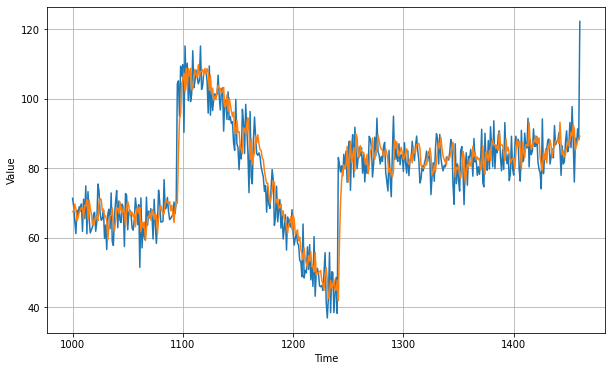

In [7]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0111694

## Deep neural network

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

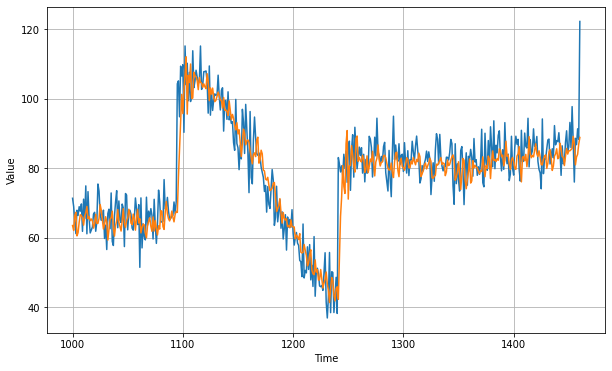

In [11]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0324693

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule] ,verbose=0)

(1e-08, 0.001, 0.0, 300.0)

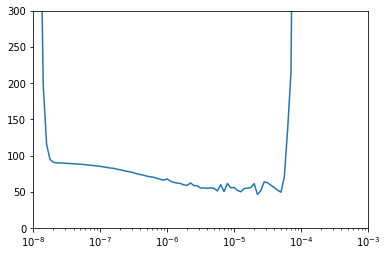

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [17]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

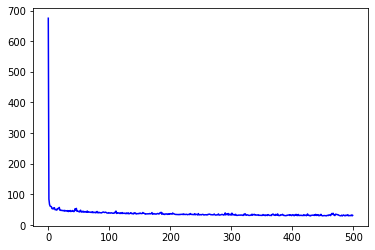

In [18]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[56.044044494628906, 49.652774810791016, 49.59543228149414, 50.291107177734375, 48.23577880859375, 53.250484466552734, 53.267086029052734, 52.925716400146484, 57.04090118408203, 47.980472564697266, 47.88612747192383, 47.06528091430664, 47.909568786621094, 46.623844146728516, 46.82882308959961, 46.948974609375, 45.292667388916016, 47.491756439208984, 45.443626403808594, 45.817726135253906, 46.26166915893555, 44.13773727416992, 46.75022506713867, 43.493560791015625, 46.20890426635742, 45.012516021728516, 47.0499382019043, 43.47468948364258, 44.92268753051758, 44.976417541503906, 47.000118255615234, 44.23146057128906, 43.44977569580078, 45.342899322509766, 52.96163558959961, 48.482967376708984, 53.892547607421875, 44.31937789916992, 45.51880645751953, 44.40764617919922, 43.21027374267578, 42.2271728515625, 46.2239990234375, 48.00608444213867, 41.77235794067383, 42.55894088745117, 44.39274597167969, 42.257530212402344, 44.29963684082031, 41.795921325683594, 42.6942253112793, 42.19551086425

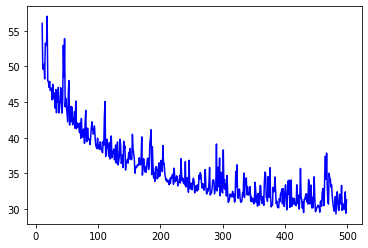

In [19]:
# Plot all bu the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

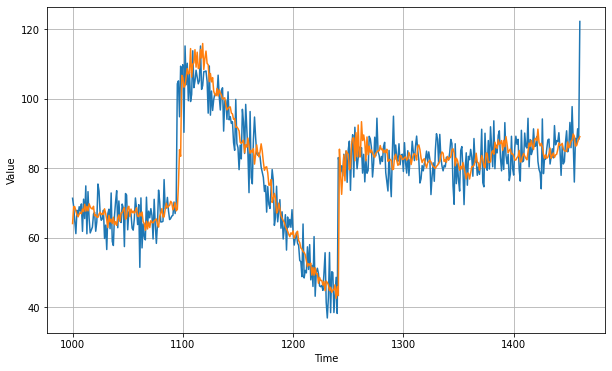

In [20]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.864325